**Contexto y definición de los datos**

BOXNOX es una empresa dedicada a la distribución y venta directa de productos de perfumería y cosmética de nicho. Además de comercializar en España, Andorra y Portugal, el canal Online ha iniciado su actividad a nivel europeo.

Este creicmiento de la actividad comercial destapa problemáticas derivadas de la gestión de stock, como faltas de aprovisionamiento, altos niveles de stock inmovilizado y, a consecuencia de ello, pérdida de ventas y costes innecesarios.

Para solventarlo, se propone una solución basada en Machine Learning donde, a través de la predicción de demanda, se evaluará si los niveles actuales de stock son los óptimos, y así poder plantear estrategias operativas que mejoren la problemática de la empresa.

Para esta primera versión del proyecto, se toma como punto de partida la gestión de la marca Diptyque, la más potente y problemática que dispone la empresa debido al gran número de referencias y el alto volumen de ventas. Además, como únicamente contamos con un histórico de ventas de dos años, se tomarán en cuenta aquellos puntos de venta propios que dispongan de esta marca durante este periodo, excluyendo las nuevas aperturas.

En una primera instancia, nos centraremos en el canal de ventas Retail, ya que estos puntos de venta almacenan su propio stock, mientras que el canal Online y la distribución se nutren de unos almacenes logísticos independientes a la empresa.

Para considerar estas predicciones, tendremos en cuenta los siguientes datos:
1. **fecha**: correspondiente a la fecha en la que se efectúa el pedido de venta
2. **punto_venta**: responde a la tienda desde donde se efectúa la venta
3. **cantidad**: unidades de producto vendidas
4. **marca**: marca de cada producto vendido, en este caso, únicamente aplica Diptyque
5. **vitalicio**: referencia de producto que engloba todas las versiones disponibles del mismo

# 1. Conexión a Drive y carga del Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Ruta del Dataset
ruta = '/content/drive/MyDrive/Entrenamiento ML/export_diptyque.csv'

# Carga del fichero CSV
df_modelo = pd.read_csv(ruta)

# Primera inspeccion de datos
print(f"Dataset cargado correctamente con {len(df_modelo)} filas.")
print("\n--- Información de las columnas y tipos de datos ---")
print(df_modelo.info())

print("\n--- Primeras 5 filas del dataset ---")
display(df_modelo.head())

Dataset cargado correctamente con 58160 filas.

--- Información de las columnas y tipos de datos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58160 entries, 0 to 58159
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fecha        58160 non-null  object
 1   punto_venta  58160 non-null  object
 2   cantidad     58160 non-null  int64 
 3   marca        58160 non-null  object
 4   vitalicio    58160 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB
None

--- Primeras 5 filas del dataset ---


,fecha,punto_venta,cantidad,marca,vitalicio
0,2024-01-02 09:04:23,SER,1,DIPTYQUE,TB1
1,2024-01-02 09:07:34,CAS,-1,DIPTYQUE,FLEURP75C
2,2024-01-02 09:08:28,SER,1,DIPTYQUE,SENS50V1
3,2024-01-02 09:15:58,SER,1,DIPTYQUE,VA1
4,2024-01-02 09:15:58,SER,1,DIPTYQUE,OU1


Con esta información podemos concluir con lo siguiente:
1. Debemos valorar si conservamos las devoluciones o las omitimos, ya que no podemos permitir valores negativos en el conjunto de cara a la predicción
2. La columna 'fecha' de define como un objeto, por lo que le debemos dar formato datetime
3. La variable 'fecha' tiene demasiado nivel de detalle; de cara a la predicción de la demanda, la hora no aporta valor, por lo que debemos agrupar los valores por tienda y fecha con el sumatorio de la cantidad vendida total


# 2. Limpieza de datos

In [3]:
# Formato de fecha a datetime
df_modelo['fecha'] = pd.to_datetime(df_modelo['fecha'])
df_modelo['fecha_dia'] = df_modelo['fecha'].dt.date

# Agrupación de las ventas
df_agrupado = df_modelo.groupby(['punto_venta', 'fecha_dia', 'vitalicio']).agg({
    'cantidad': 'sum'
}).reset_index()

# Comporbación de negativos después de la agrupación
negativos_post = df_agrupado[df_agrupado['cantidad'] < 0]

print(f"RESUMEN")
print(f"Registros originales: {len(df_modelo)}")
print(f"Registros tras agrupación: {len(df_agrupado)}")
print(f"Casos con sumatorio negativo tras agrupar: {len(negativos_post)}")

if len(negativos_post) > 0:
    print("\n Muestra de registros que siguen siendo negativos:")
    display(negativos_post.head())

print("\nNUEVO DATASET")
display(df_agrupado.head())

RESUMEN
Registros originales: 58160
Registros tras agrupación: 50721
Casos con sumatorio negativo tras agrupar: 864

 Muestra de registros que siguen siendo negativos:


,punto_venta,fecha_dia,vitalicio,cantidad
7,AND,2024-01-04,CAPIHMIST,-1
8,AND,2024-01-04,CAPITAP75C,-1
10,AND,2024-01-04,TB1,-1
215,AND,2024-05-31,SOLIDE34,-1
294,AND,2024-07-29,MINTP75C,-1



NUEVO DATASET


,punto_venta,fecha_dia,vitalicio,cantidad
0,AND,2024-01-02,ORPHP75C,1
1,AND,2024-01-02,PHILOP75,1
2,AND,2024-01-02,SOLIDECAPI,1
3,AND,2024-01-02,SOLIDEROSE,1
4,AND,2024-01-03,SOLIDEDOSON,1


* De cara al entrenamiento, se convertirán los valores negativos a 0, evitando la
predicción de ventas negativas
* El modelo de predicciones necesita un dataset completo, donde se incluya información de todas las referencias cada día, incluyendo ceros (0) los días que no se haya vendido nada

In [4]:
# Conversión de los 864 negativos a 0
df_agrupado.loc[df_agrupado['cantidad'] < 0, 'cantidad'] = 0

# Verficación
print(f"Negativos tras limpieza: {len(df_agrupado[df_agrupado['cantidad'] < 0])}")

# Aálisis de 'Huecos Temportales' para ver cuántos días únicos tenemos por tienda
resumen_fechas = df_agrupado.groupby('punto_venta')['fecha_dia'].agg(['min', 'max', 'nunique']).reset_index()
display(resumen_fechas)

Negativos tras limpieza: 0


,punto_venta,min,max,nunique
0,AND,2024-01-02,2025-12-31,463
1,CAS,2024-01-02,2025-12-31,718
2,CC85,2024-01-02,2025-12-31,577
3,MAR,2024-01-02,2025-12-31,662
4,SAL,2024-01-02,2025-12-30,596
5,SER,2024-01-02,2025-12-31,720
6,ZGZ,2024-01-02,2025-12-30,553


Una vez comporbado que el Dataset ya no dispone de negativos, se procede a la generación de un calendario completo con la finalidad de combinar cada vitalicio con cada punto de venta, donde se le asignará un valor de 0 ventas.

In [5]:
import pandas as pd

# Creación del rango de fechas completo
fecha_inicio = df_agrupado['fecha_dia'].min()
fecha_fin = df_agrupado['fecha_dia'].max()
calendario = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D').date

# Combinaciones entre punto de venta y vitalicio
tiendas = df_agrupado['punto_venta'].unique()
productos = df_agrupado['vitalicio'].unique()
index = pd.MultiIndex.from_product(
    [tiendas, calendario, productos],
    names=['punto_venta', 'fecha_dia', 'vitalicio']
)
df_completo = pd.DataFrame(index=index).reset_index()

# Unificación de los datos reales con la normalización
df_final = pd.merge(df_completo, df_agrupado, on=['punto_venta', 'fecha_dia', 'vitalicio'], how='left')

# Completar los NaN
df_final['cantidad'] = df_final['cantidad'].fillna(0)

# Verificación final
print(f"Total de filas: {len(df_final)}")
display(df_final.head())

Total de filas: 2616320


,punto_venta,fecha_dia,vitalicio,cantidad
0,AND,2024-01-02,ORPHP75C,1.0
1,AND,2024-01-02,PHILOP75,1.0
2,AND,2024-01-02,SOLIDECAPI,1.0
3,AND,2024-01-02,SOLIDEROSE,1.0
4,AND,2024-01-02,SOLIDEDOSON,0.0


Con esta normalización, se consigue un incremento de las filas del Dataset hasta alcanzar los 2.616.320 registros. De esta manera, se comprueba que el Dataset cuenta con una fila para cada día entre enero de 2024 hasta diciembre de 2025 por cada tienda. La gran mayoría de estas filas constarán con 0 registros de venta.

Se procede a verificar que la línea temporal se mantiene fluida eligiendo uno de los productos más populares con la finalidad de graficarlo y visualizar su evolución en el tiempo.

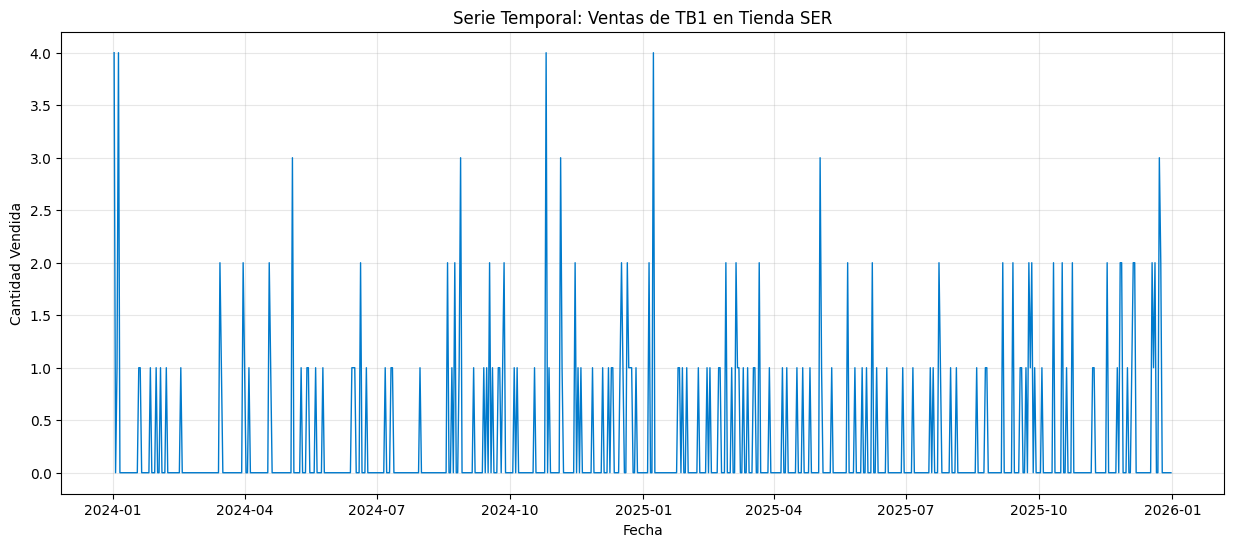

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de tienda y referencia
tienda_test = 'SER'
producto_test = 'TB1'

df_plot = df_final[(df_final['punto_venta'] == tienda_test) &
                   (df_final['vitalicio'] == producto_test)].copy()

# Establecemos el orden cronológico
df_plot = df_plot.sort_values('fecha_dia')

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(df_plot['fecha_dia'], df_plot['cantidad'], color='#007acc', linewidth=1)
plt.title(f'Serie Temporal: Ventas de {producto_test} en Tienda {tienda_test}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.grid(True, alpha=0.3)
plt.show()

Los resultados arrojados indican un comportamiento esperado de los datos, donde se muestra una demanda intermitente a lo largo de la línea temporal.

Con la finalidad de enriquecer el Dataset, se procede a la Ingeniería de Variables (Feature Engineering) con la finalidad de extraer patrones de la columna fecha_dia

In [7]:
# Aseguramos el formato de fecha
df_final['fecha_dia'] = pd.to_datetime(df_final['fecha_dia'])

# Variables básicas del calendario
df_final['dia_semana'] = df_final['fecha_dia'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_final['mes'] = df_final['fecha_dia'].dt.month
df_final['es_fin_de_semana'] = df_final['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

# 2. Variables de "Memoria" (Lags); le enseña al modelo lo que se vendió el día anterior
# Agrupamos por tienda y producto para que el 'shift' no mezcle datos
df_final = df_final.sort_values(['punto_venta', 'vitalicio', 'fecha_dia'])
df_final['ventas_ayer'] = df_final.groupby(['punto_venta', 'vitalicio'])['cantidad'].shift(1)

# Cálculo de la media móvil (promedio de ventas de los últimos 7 días)
df_final['media_7dias'] = df_final.groupby(['punto_venta', 'vitalicio'])['cantidad'].transform(lambda x: x.rolling(window=7).mean())

# Eliminación de las filas que constan como NaN debido al desplazamiento (los primeros días de 2024)
df_final = df_final.dropna()

print("Variables enriquecidas correctamente.")
display(df_final.head())

Variables enriquecidas correctamente.


,punto_venta,fecha_dia,vitalicio,cantidad,dia_semana,mes,es_fin_de_semana,ventas_ayer,media_7dias
3287,AND,2024-01-08,34B1500,0.0,0,1,0,0.0,0.0
3799,AND,2024-01-09,34B1500,0.0,1,1,0,0.0,0.0
4311,AND,2024-01-10,34B1500,0.0,2,1,0,0.0,0.0
4823,AND,2024-01-11,34B1500,0.0,3,1,0,0.0,0.0
5335,AND,2024-01-12,34B1500,0.0,4,1,0,0.0,0.0


La generación de variables apoyarán al modelo a predecir la demanda en base a las siguientes predictoras:
* ventas_ayer y media_7dias le indican al modelo si un producto está "de moda" o tiene una tendencia al alza en una tienda específica
* dia_semana y es_fin_de_semana permiten al algoritmo a detectar si la marca se vende más algún día concreto o tiene una tendencia lineal

Con la finalidad de refinar la predicción, se procede a la inclusión de los días festivos

In [8]:
!pip install holidays -q
import holidays

# Configuración de los festivos en ambos años
festivos_es = holidays.Spain(years=[2024, 2025])

# Creación de la nueva variable
df_final['es_festivo'] = df_final['fecha_dia'].apply(lambda x: 1 if x in festivos_es else 0)

# Tenemos en cuenta las vísperas de festivo
df_final['vispera_festivo'] = df_final['es_festivo'].shift(-1).fillna(0).astype(int)

# Comporbación de los resultados
print(f"Festivos añadidos. Días festivos detectados: {df_final['es_festivo'].sum()}")
display(df_final[df_final['es_festivo'] == 1][['fecha_dia', 'es_festivo', 'vispera_festivo']].head(10))

Festivos añadidos. Días festivos detectados: 57344


,fecha_dia,es_festivo,vispera_festivo
44759,2024-03-29,1,0
61655,2024-05-01,1,0
115927,2024-08-15,1,0
145623,2024-10-12,1,0
155863,2024-11-01,1,0
173783,2024-12-06,1,0
183511,2024-12-25,1,0
187095,2025-01-01,1,0
189655,2025-01-06,1,0
241879,2025-04-18,1,0


Con la inclusión de las nuevas variables, el Dataset consta de 2,6 millones de filas, lo que demuestra consistencia en el conjunto.

# 3. Entrenamiento del modelo

Debido a la naturaleza temporal del conjunto de datos, es necesario particionarlos de manera ordenada para su entrenamiento, por lo que se procede a prepararlo de la siguiente manera:
* Entrenameinto: todo el año 2024 y hasta finales de septiembre de 2025
* Test: último trimestre de 2025

In [10]:
# 1. DIVISIÓN DEL CONJUNTO EN ENTRENAMIENTO Y TEST
fecha_corte = pd.to_datetime('2025-10-01')

train = df_final[df_final['fecha_dia'] < fecha_corte].copy()
test = df_final[df_final['fecha_dia'] >= fecha_corte].copy()

# 2. SELECCIÓN DE VARIABLES Y CREACIÓN DE X E Y
# Busca esta línea en tu notebook y añade 'stock_actual'
features = ['punto_venta', 'vitalicio', 'dia_semana', 'mes', 'es_fin_de_semana',
            'ventas_ayer', 'media_7dias', 'es_festivo', 'vispera_festivo']

X_train = train[features].copy()
y_train = train['cantidad']

X_test = test[features].copy()
y_test = test['cantidad']


# USO DE LABEN ENCODING (DESCARTADO)
#Se probó inicialmente esta técnica, pero se identificó que introducía una jerarquía numérica artificial que confundía al modelo.

# from sklearn.preprocessing import LabelEncoder
# le_tienda = LabelEncoder()
# X_train['punto_venta'] = le_tienda.fit_transform(X_train['punto_venta'])
# X_test['punto_venta'] = le_tienda.transform(X_test['punto_venta'])

# USO DE TARGET ENCODING (SELECCIONADO)
# Implementado para capturar la fuerza de venta real de cada tienda y eliminar sesgos jerárquicos.
media_global = y_train.mean()
m = 10

stats = train.groupby('punto_venta')['cantidad'].agg(['mean', 'count'])
valor_target = (stats['count'] * stats['mean'] + m * media_global) / (stats['count'] + m)
mapeo_tienda = valor_target.to_dict()

X_train['punto_venta'] = X_train['punto_venta'].map(mapeo_tienda)
X_test['punto_venta'] = X_test['punto_venta'].map(mapeo_tienda)

X_test['punto_venta'] = X_test['punto_venta'].fillna(media_global)

from sklearn.preprocessing import LabelEncoder
le_prod = LabelEncoder()
X_train['vitalicio'] = le_prod.fit_transform(X_train['vitalicio'])
X_test['vitalicio'] = le_prod.transform(X_test['vitalicio'])

print(f"Ejemplo de valor en punto_venta: {X_train['punto_venta'].iloc[0]:.4f}")

Ejemplo de valor en punto_venta: 0.0036


Con estos resultados, confirmamos que el proceso se ha completado correctamente, ya que este resultado informa sobre la media de unidades vendidas en el punto de venta, permitiendo al modelo XGBoost identificar qué puntos de venta realizan más ventas sin necesidad de especificarlo de forma concreta.

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# CREACIÓN DEL MODELO
modelo_diptyque = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1  # Usa todos los núcleos para ir más rápido
)

# ENTRENAMIENTO
modelo_diptyque.fit(X_train, y_train)

# PREDICCIÓN
predicciones = modelo_diptyque.predict(X_test)

# EVALUACIÓN CON EL MAE
mae = mean_absolute_error(y_test, predicciones)
print(f"Error Medio Absoluto (MAE): {mae:.4f}")

Error Medio Absoluto (MAE): 0.0449


Con estos resultados, podemos concluir con que el modelo se equivoca 0.04 unidades al predecir la venta diaria de un producto, lo que demuestra un gran nivel de precisión.

En este punto del modelado, se procede a determinar qué variables son las más relevantes en la predicción.

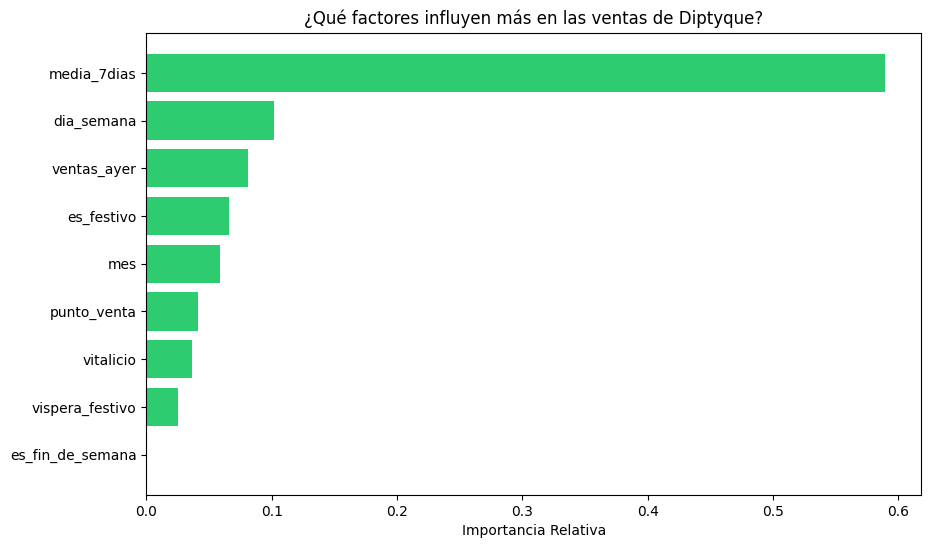

In [12]:
import matplotlib.pyplot as plt

importancias = modelo_diptyque.feature_importances_
nombres_features = features

# Visualización
plt.figure(figsize=(10, 6))
indices = importancias.argsort()
plt.barh(range(len(indices)), importancias[indices], color='#2ecc71', align='center')
plt.yticks(range(len(indices)), [nombres_features[i] for i in indices])
plt.title('¿Qué factores influyen más en las ventas de Diptyque?')
plt.xlabel('Importancia Relativa')
plt.show()

* Con una importancia relativa de más del 55%, el modelo nos muestra la gran relevancia que toma media_7dias. En la comercialización del lujo en el canal Retail, esto muestra una fuerte relevancia en la tendencia local
* dia_semana y es_festivo, muestran un impacto directo de casi el 20% de impacto, lo que confirma que se trata de ventas ligadas al ocio y al calendario comercial español
* es_fin_de_semana muestra una importancia inexistente, lo que significa que es una variable que no ayuda a las predicciones. En este caso XGBoost adquiere esta información a través de la variable dia_semana, por lo que renuncia de la variable redundante

# 4. Comporbación de resultados

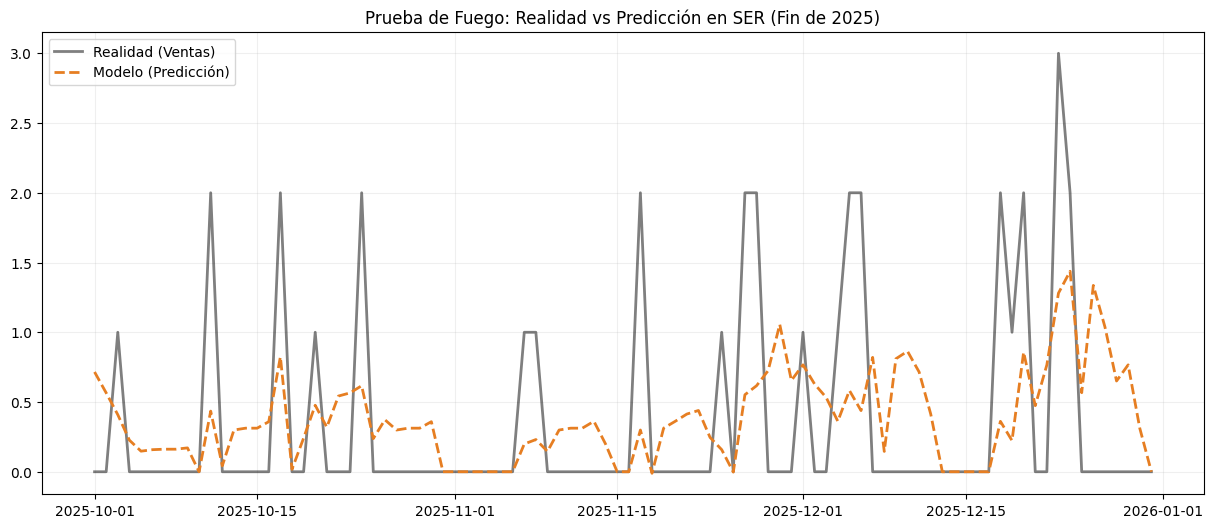

In [13]:
import matplotlib.pyplot as plt

# Inclusión de las predicciones al dataset de test para comprobarlas
test_con_pred = test.copy()
test_con_pred['prediccion'] = predicciones

# Elaboramos la prueba con un punto y producto específico
tienda_zoom = 'SER'
prod_zoom = 'TB1'

filtro = (test_con_pred['punto_venta'] == tienda_zoom) & (test_con_pred['vitalicio'] == prod_zoom)
df_final_test = test_con_pred[filtro].sort_values('fecha_dia')

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(df_final_test['fecha_dia'], df_final_test['cantidad'], label='Realidad (Ventas)', color='black', alpha=0.5, linewidth=2)
plt.plot(df_final_test['fecha_dia'], df_final_test['prediccion'], label='Modelo (Predicción)', color='#e67e22', linestyle='--', linewidth=2)

plt.title(f'Prueba de Fuego: Realidad vs Predicción en {tienda_zoom} (Fin de 2025)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Con la obtención de estos resultados, se procede a concluir con lo siguiente:
* Obtenemos una sincronía temporal donde, como se aprecia en la gráfica, se aprencia en los picos de demanda reales y esperados
* En los periodos donde las ventas disminuyen, la predicción también me mantiene baja
* Al ser un modelo estadístico tiende a ser conservador, lo que nos indica que el modelo no está sobreajustado